![title](img/quora.gif)

# Quora Question Pairs

### Can you identify question pairs that have the same intent?

**Description:**

Where else but Quora can a physicist help a chef with a math problem and get cooking tips in return? Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

**Evaluation:** Submissions are evaluated on the log loss between the predicted values and the ground truth.  
**Prices:** 1st place - $12,500, 2nd place - $8,500, 3rd place - $4,000.  
**Timeline:** June 6, 2017 - Final submission deadline.

Great sources that you have to check:
- https://www.kaggle.com/anokas/quora-question-pairs/data-analysis-xgboost-starter-0-35460-lb
- https://www.kaggle.com/philschmidt/quora-question-pairs/quora-eda-model-selection-roc-pr-plots
- https://www.kaggle.com/sudalairajkumar/quora-question-pairs/simple-exploration-notebook-quora-ques-pair
- https://www.kaggle.com/puneetsl/quora-question-pairs/unusual-meaning-map
- https://www.kaggle.com/artimous/quora-question-pairs/real-data-scientists-train-hard 


*Others sources are directly indicated in the notebook below*

***

# Libraries

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd

In [6]:
# Text analytic
import csv
import pip
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
#nltk.download('stopwords')
#nltk.download('punkt')
eng_stopwords = set(stopwords.words('english'))

In [7]:
# Visualisation
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline
from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Machine learning
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
import xgboost as xgb

***

# 1. Data exploration
## 1.1. The data quality report

In [9]:
punctuation='["\'?,\.]' # I will replace all these punctuation with ''
abbr_dict={
    "what's":"what is",
    "what're":"what are",
    "who's":"who is",
    "who're":"who are",
    "where's":"where is",
    "where're":"where are",
    "when's":"when is",
    "when're":"when are",
    "how's":"how is",
    "how're":"how are",

    "i'm":"i am",
    "we're":"we are",
    "you're":"you are",
    "they're":"they are",
    "it's":"it is",
    "he's":"he is",
    "she's":"she is",
    "that's":"that is",
    "there's":"there is",
    "there're":"there are",

    "i've":"i have",
    "we've":"we have",
    "you've":"you have",
    "they've":"they have",
    "who've":"who have",
    "would've":"would have",
    "not've":"not have",

    "i'll":"i will",
    "we'll":"we will",
    "you'll":"you will",
    "he'll":"he will",
    "she'll":"she will",
    "it'll":"it will",
    "they'll":"they will",

    "isn't":"is not",
    "wasn't":"was not",
    "aren't":"are not",
    "weren't":"were not",
    "can't":"can not",
    "couldn't":"could not",
    "don't":"do not",
    "didn't":"did not",
    "shouldn't":"should not",
    "wouldn't":"would not",
    "doesn't":"does not",
    "haven't":"have not",
    "hasn't":"has not",
    "hadn't":"had not",
    "won't":"will not",
    punctuation:'',
    '\s+':' ', # replace multi space with one single space
}

# Source:https://www.kaggle.com/life2short/quora-question-pairs/data-processing-replace-abbreviation-of-word

In [10]:
def process_data(file_name):
    data=pd.read_csv(file_name)
    data.question1=data.question1.str.lower() # conver to lower case
    data.question2=data.question2.str.lower()
    data.question1=data.question1.astype(str)
    data.question2=data.question2.astype(str)
    data.replace(abbr_dict,regex=True,inplace=True)
    display(data.head(2))
    return data

In [11]:
# pd.set_option('display.max_colwidth',-1) # set max col width in order we can some more content

train_df=process_data('Data/train.csv').fillna("")
test_df=process_data('Data/test.csv').fillna("")

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0


,test_id,question1,question2
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...
1,1,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require


In [12]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


**Data fields**
- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [13]:
#check missing values
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## 1.2. First visualisations

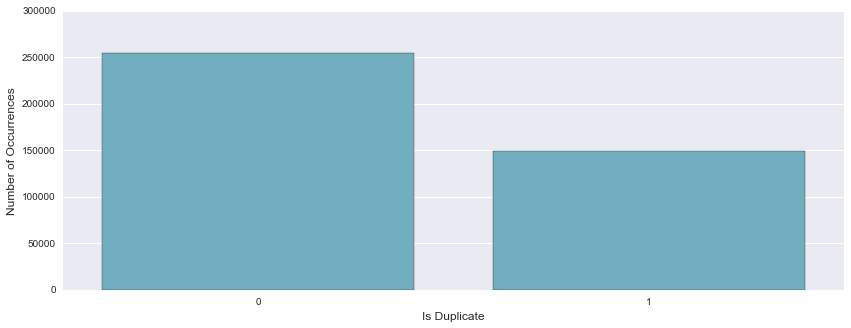

In [14]:
# Get duplicated
is_dup = train_df['is_duplicate'].value_counts()

# Plot duplicated
plt.figure(figsize=(14,5))
sns.barplot(is_dup.index, is_dup.values, alpha=1, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.show()

In [15]:
print('duplicated = 1 and non-duplicated = 0 (in % ) {}'.format((is_dup / is_dup.sum())*100))

duplicated = 1 and non-duplicated = 0 (in % ) 0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


In [16]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns = ["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x : len(str(x).split()))

In [17]:
all_ques_df.head()

,questions,num_of_words
0,what is the step by step guide to invest in sh...,14
1,what is the story of kohinoor (koh-i-noor) dia...,8
2,how can i increase the speed of my internet co...,14
3,why am i mentally very lonely how can i solve it,11
4,which one dissolve in water quikly sugar salt ...,13


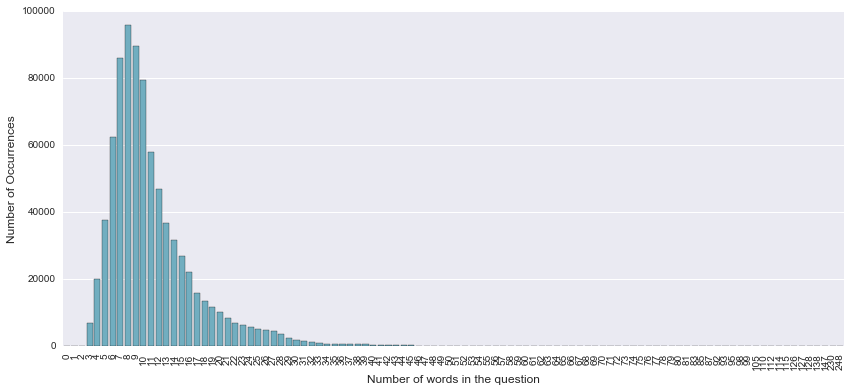

In [18]:
# Count the total number of words
cnt_srs = all_ques_df['num_of_words'].value_counts()

# Plot the distribution of the number of words per question.
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

We can see that the distribution is right skewed, as we have a very long tail that contain outliers from 28 to 237 words. 

In [19]:
# Let's do the same for the characters
# Create a columns for characters and take then from the column question
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x : len(str(x)))
all_ques_df.head()

,questions,num_of_words,num_of_chars
0,what is the step by step guide to invest in sh...,14,65
1,what is the story of kohinoor (koh-i-noor) dia...,8,50
2,how can i increase the speed of my internet co...,14,72
3,why am i mentally very lonely how can i solve it,11,48
4,which one dissolve in water quikly sugar salt ...,13,73


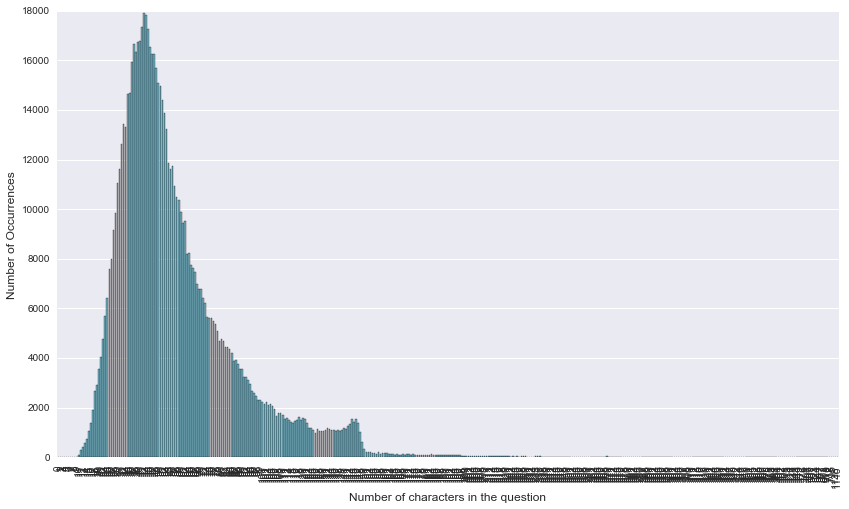

In [20]:
# Count the number of words
cnt_srs = all_ques_df['num_of_chars'].value_counts()

# Plot the number of words per question
plt.figure(figsize=(14,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=1, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of characters in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Of course, the number of characters is also right skewed like the number of words. But, we can see that Quora must have added a limit (at 150) as the tail is sharply cut. Maybe Quora only accept numbers, and/or punctuation after this mark, that will explain our two distributions.

In [21]:
# More exploration
print('Total number of question pairs for training: {}'.format(len(train_df)))
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() > 1)))

Total number of question pairs for training: 404290
Number of questions that appear multiple times: 111780


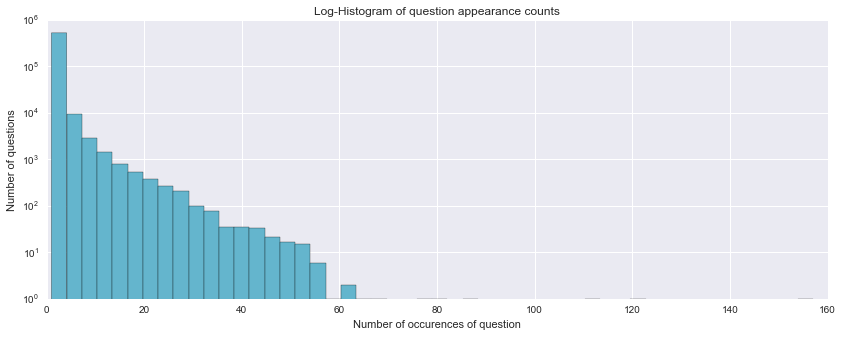

In [22]:
# Plot
plt.figure(figsize=(14, 5))
plt.hist(qids.value_counts(), bins=50, color=color[5])
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

Most questions only appear a few times, with very few questions appearing several times. We have a outlier at 160.

### Let's have a look at the test set compared to our training set:

mean-train 58.50 std-train 31.55 mean-test 58.72 std-test 31.20 max-train 1140.00 max-test 1145.00


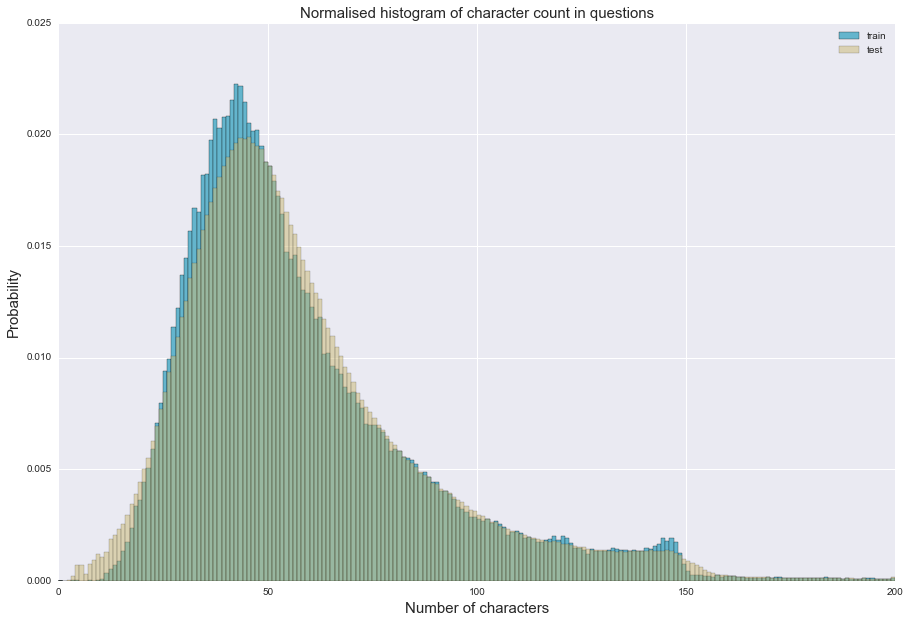

In [23]:
pal = sns.color_palette()

train_qs = pd.Series(train_df['question1'].tolist() + train_df['question2'].tolist()).astype(str)
test_qs = pd.Series(test_df['question1'].tolist() + test_df['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)

# Plot
plt.figure(figsize=(15, 10))
# Histogram for the train data
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[5], normed=True, label='train')
# Histogram for the test data
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[4], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 11.11 std-train 5.95 mean-test 11.07 std-test 5.90 max-train 248.00 max-test 249.00


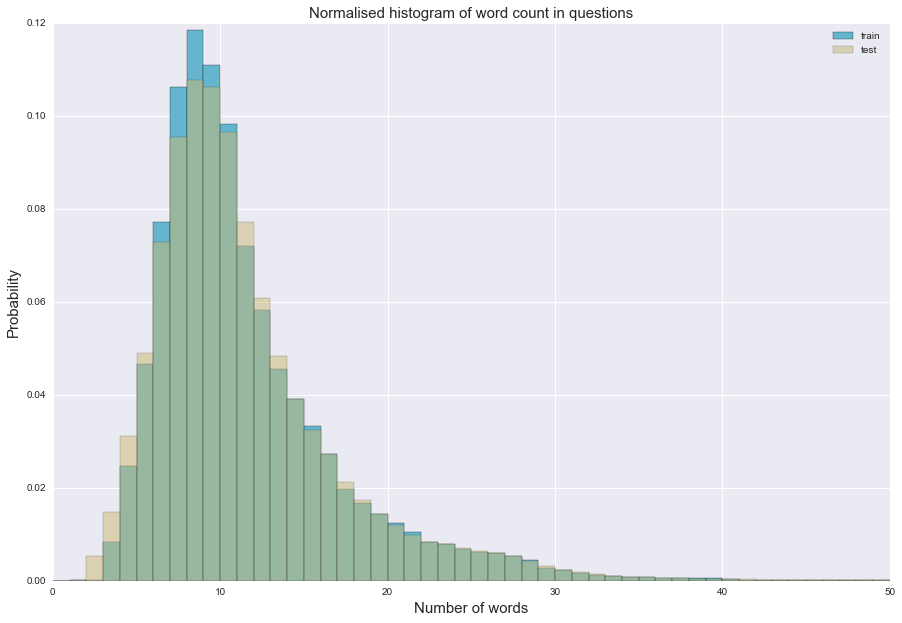

In [24]:
dist_train = train_qs.apply(lambda x: len(x.split(' ')))
dist_test = test_qs.apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=50, range=[0, 50], color=pal[5], normed=True, label='train')
plt.hist(dist_test, bins=50, range=[0, 50], color=pal[4], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

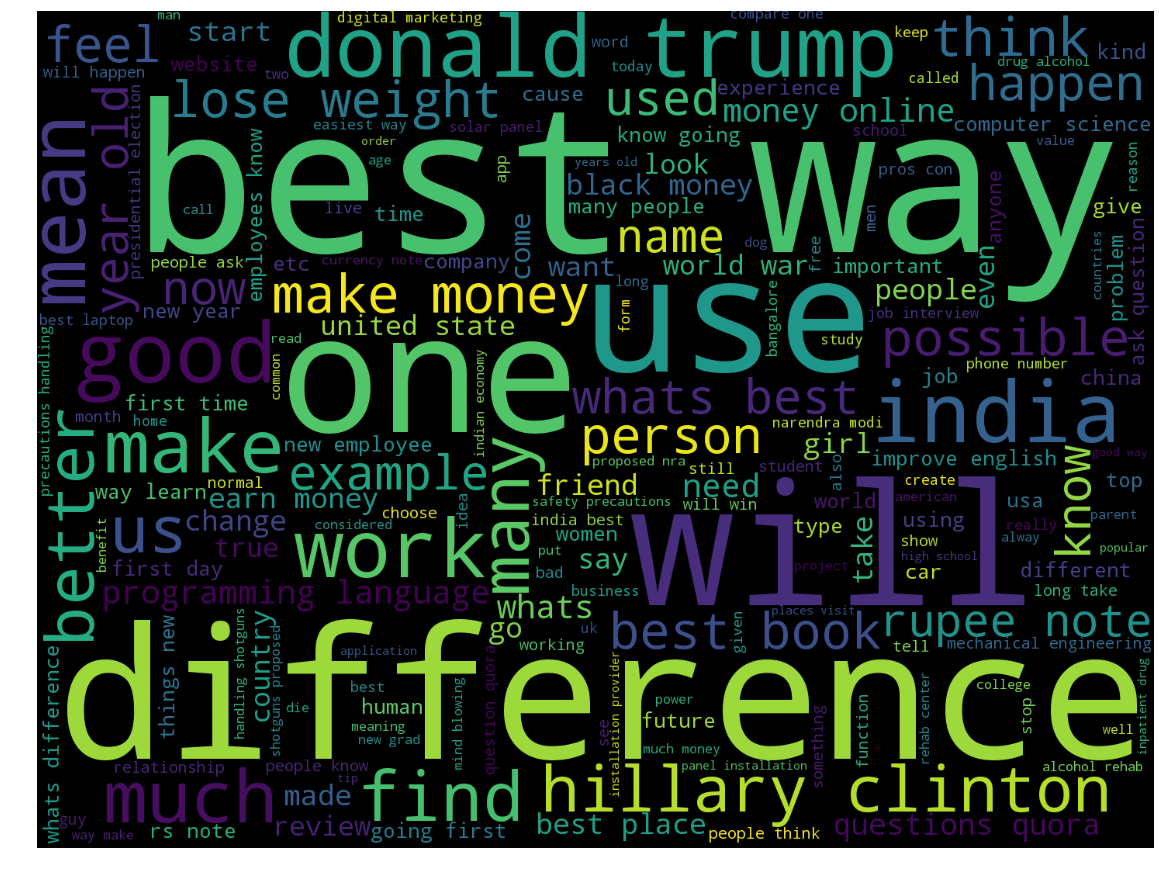

In [25]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

#### Duplicates of Duplicates  

Sources: https://www.kaggle.com/davidthaler/quora-question-pairs/duplicates-of-duplicates


In [26]:
import networkx as nx
pos = train_df[train_df.is_duplicate==1]
g = nx.Graph()
g.add_nodes_from(pos.question1)
g.add_nodes_from(pos.question2)
edges = list(pos[['question1', 'question2']].to_records(index=False))
g.add_edges_from(edges)
len(set(pos.question1) | set(pos.question2)), g.number_of_nodes()

(148936, 148936)

In [27]:
d = g.degree()
np.mean([d[k] for k in d])

1.9939974217113392

In [28]:
cc = filter(lambda x : (len(x) > 3) and (len(x) < 10), 
            nx.connected_component_subgraphs(g))
g1 = next(cc)
g1.nodes()

['is it really true that us is backing isis',
 'is it true that the us is funding isis',
 'do you think that us funds isis',
 'is it true that the rothschilds funded isis',
 'why does the us so covertly fund isis',
 'is it true that isis has been created and funded by the west',
 'is daesh (isis) covertly funded by us intelligence']

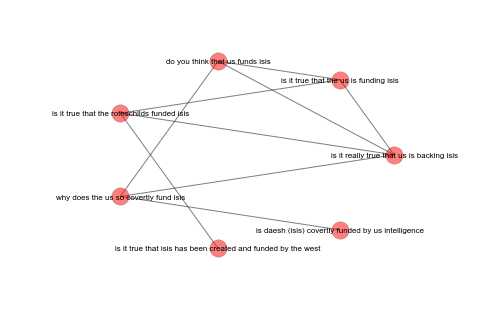

In [29]:
# with block handles a deprecation warning that occurs inside nx.draw_networkx
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nx.draw_circular(g1, with_labels=True, alpha=0.5, font_size=8)
    plt.show()

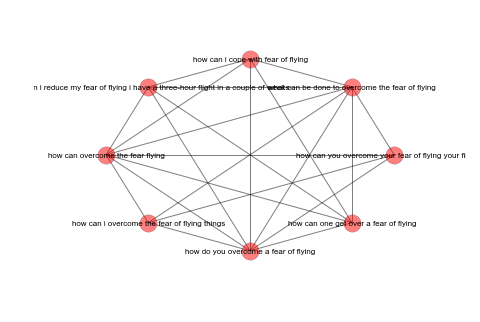

In [30]:
g1 = next(cc)
#g1.nodes()
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    nx.draw_circular(g1, with_labels=True, alpha=0.5, font_size=8)
    plt.show()

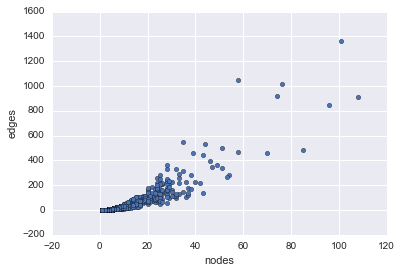

In [31]:
cc = nx.connected_component_subgraphs(g)
node_cts = list(sub.number_of_nodes() for sub in cc)
cc = nx.connected_component_subgraphs(g)
edge_cts = list(sub.number_of_edges() for sub in cc)
cts = pd.DataFrame({'nodes': node_cts, 'edges': edge_cts})
cts['mean_deg'] = 2 * cts.edges / cts.nodes
cts.nodes.clip_upper(10).value_counts().sort_index()
cts.plot.scatter('nodes', 'edges')
plt.show()

***

# 2. Feature engineering

### 2.1. Basic features

- character length of questions 1 and 2
- number of words in question 1 and 2
- normalized word share count.

In [43]:
# To much data to concat now
#trainnnn = pd.concat([train_df, test_df])
#def ingest_data():
#    train = train_df.assign(Train = 1)
#    test = test_df.assign(Train = 0)
#            #.assign(is_duplicate = -999)[list(train)])
#    return pd.concat([train, test])
#
#data = ingest_data()
#data.head()

In [44]:
#train_df = pd.read_csv("Data/train.csv").fillna("")
train_df['q1len'] = train_df['question1'].str.len()
train_df['q2len'] = train_df['question2'].str.len()

train_df['q1_n_words'] = train_df['question1'].apply(lambda row: len(row.split(" ")))
train_df['q2_n_words'] = train_df['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

train_df['word_share'] = train_df.apply(normalized_word_share, axis=1)

train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,0.478261
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,50,87,8,13,0.250000
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,0.166667
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when [math]23^{24}[/math] i...,0,48,63,11,9,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,73,38,13,7,0.200000


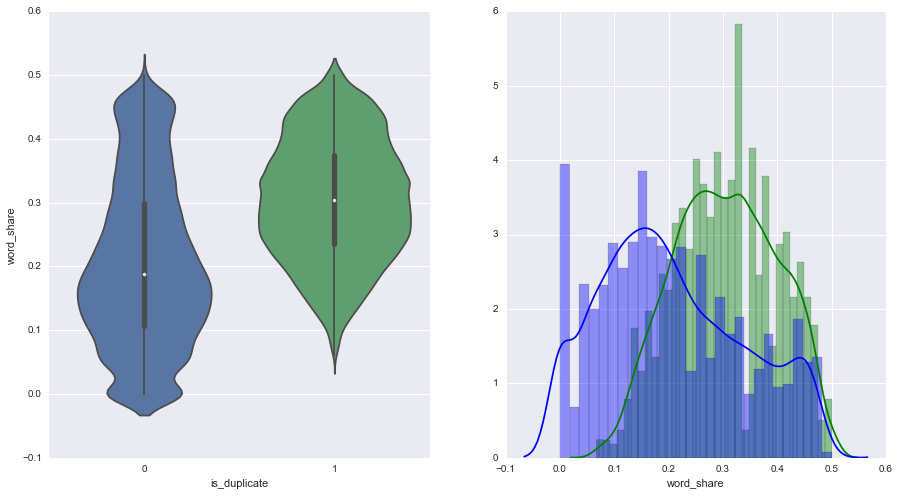

In [45]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
#sns.boxplot(x="is_duplicate", y="word_share", data = df[0:50000])
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = train_df[0:50000])
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1.0]['word_share'][0:10000], color = 'green')
sns.distplot(train_df[train_df['is_duplicate'] == 0.0]['word_share'][0:10000], color = 'blue')

## 2.2. Unigrams

In [46]:
# Get unigrams from question
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

# Count the common unigrams
def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) )

# Compute the ratio of common unigrams
def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

# Apply the 3 above functions to our train dataset.
train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row),axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

In [47]:
# Here is the results
train_df[train_df['is_duplicate'] == 1.0].head(n=3)

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio
5,5,11,12,astrology: i am a capricorn sun cap moon and c...,i am a triple capricorn (sun moon and ascendan...,1,82,89,16,17,0.312500,"[astrology, :, capricorn, sun, cap, moon, cap,...","[triple, capricorn, (, sun, moon, ascendant, c...",4,0.333333
7,7,15,16,how can i be a good geologist,what should i do to be a great geologist,1,29,40,7,9,0.250000,"[good, geologist]","[great, geologist]",1,0.333333
11,11,23,24,how do i read and find my youtube comments,how can i see all my youtube comments,1,42,37,9,8,0.294118,"[read, find, youtube, comments]","[see, youtube, comments]",2,0.400000


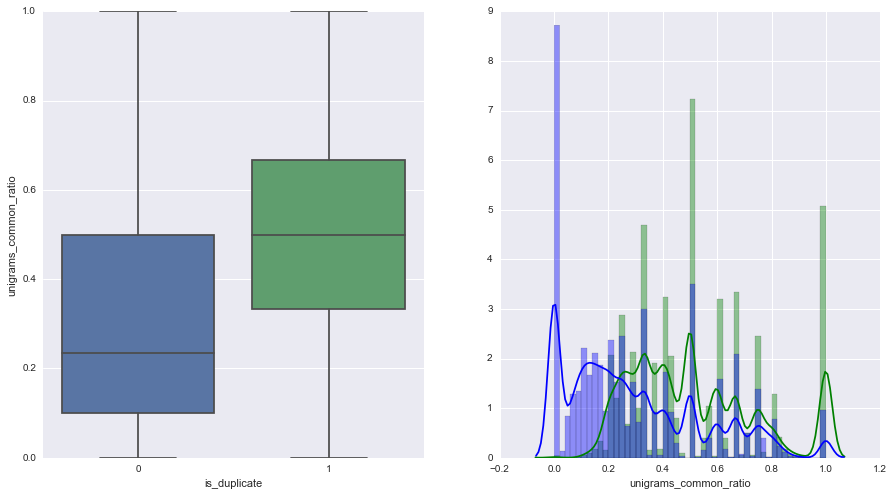

In [48]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.boxplot(x="is_duplicate", y="unigrams_common_ratio", data=train_df)
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1.0]['unigrams_common_ratio'][:], color = 'green')
sns.distplot(train_df[train_df['is_duplicate'] == 0.0]['unigrams_common_ratio'][:], color = 'blue')

## 2.3. Bigrams

In [49]:
#Same analysis using bigrams
def get_bigrams(que):
    return [i for i in ngrams(que, 2)]

def get_common_bigrams(row):
    return len( set(row["bigrams_ques1"]).intersection(set(row["bigrams_ques2"])) )

def get_common_bigram_ratio(row):
    return float(row["bigrams_common_count"]) / max(len( set(row["bigrams_ques1"]).union(set(row["bigrams_ques2"])) ),1)

# Apply the above function to our train dataset to create new features.
train_df["bigrams_ques1"] = train_df["unigrams_ques1"].apply(lambda x: get_bigrams(x))
train_df["bigrams_ques2"] = train_df["unigrams_ques2"].apply(lambda x: get_bigrams(x)) 
train_df["bigrams_common_count"] = train_df.apply(lambda row: get_common_bigrams(row),axis=1)
train_df["bigrams_common_ratio"] = train_df.apply(lambda row: get_common_bigram_ratio(row), axis=1)

In [50]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,bigrams_ques1,bigrams_ques2,bigrams_common_count,bigrams_common_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,0.478261,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",5,0.833333,"[(step, step), (step, guide), (guide, invest),...","[(step, step), (step, guide), (guide, invest),...",5,0.833333
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,50,87,8,13,0.250000,"[story, kohinoor, (, koh-i-noor, ), diamond]","[would, happen, indian, government, stole, koh...",5,0.416667,"[(story, kohinoor), (kohinoor, (), ((, koh-i-n...","[(would, happen), (happen, indian), (indian, g...",4,0.363636
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,0.166667,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",2,0.222222,"[(increase, speed), (speed, internet), (intern...","[(internet, speed), (speed, increased), (incre...",0,0.000000
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when [math]23^{24}[/math] i...,0,48,63,11,9,0.000000,"[mentally, lonely, solve]","[find, remainder, [, math, ], 23^, {, 24, }, [...",0,0.000000,"[(mentally, lonely), (lonely, solve)]","[(find, remainder), (remainder, [), ([, math),...",0,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,73,38,13,7,0.200000,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",2,0.153846,"[(one, dissolve), (dissolve, water), (water, q...","[(fish, would), (would, survive), (survive, sa...",0,0.000000


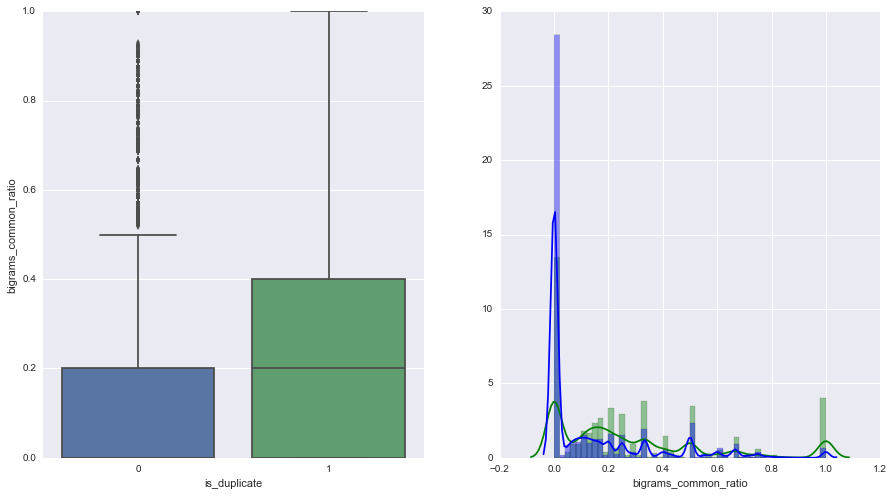

In [51]:
#Plot
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.boxplot(x="is_duplicate", y="bigrams_common_ratio", data=train_df)
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1.0]['bigrams_common_ratio'][:], color = 'green')
sns.distplot(train_df[train_df['is_duplicate'] == 0.0]['bigrams_common_ratio'][:], color = 'blue')

### 2.4. Word match share

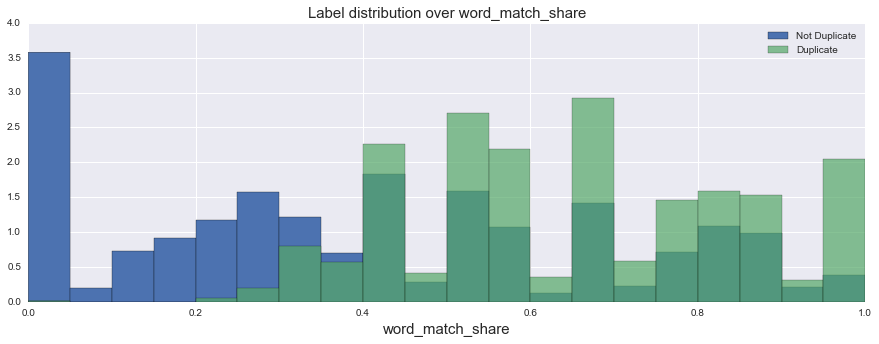

In [52]:
# Create a new feature similart to the bigram and check it's value.
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in eng_stopwords:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in eng_stopwords:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

# Apply the above function
train_word_match = train_df.apply(word_match_share, axis=1, raw=True)

# Plot the figure to check the value of our new feature.
plt.figure(figsize=(15, 5))
plt.hist(train_word_match[train_df['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[train_df['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [53]:
train_df["train_word_match"] = train_word_match

In [54]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,bigrams_ques1,bigrams_ques2,bigrams_common_count,bigrams_common_ratio,train_word_match
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,0.478261,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",5,0.833333,"[(step, step), (step, guide), (guide, invest),...","[(step, step), (step, guide), (guide, invest),...",5,0.833333,0.909091
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,50,87,8,13,0.250000,"[story, kohinoor, (, koh-i-noor, ), diamond]","[would, happen, indian, government, stole, koh...",5,0.416667,"[(story, kohinoor), (kohinoor, (), ((, koh-i-n...","[(would, happen), (happen, indian), (indian, g...",4,0.363636,0.461538
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,0.166667,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",2,0.222222,"[(increase, speed), (speed, internet), (intern...","[(internet, speed), (speed, increased), (incre...",0,0.000000,0.363636
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when [math]23^{24}[/math] i...,0,48,63,11,9,0.000000,"[mentally, lonely, solve]","[find, remainder, [, math, ], 23^, {, 24, }, [...",0,0.000000,"[(mentally, lonely), (lonely, solve)]","[(find, remainder), (remainder, [), ([, math),...",0,0.000000,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,73,38,13,7,0.200000,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",2,0.153846,"[(one, dissolve), (dissolve, water), (water, q...","[(fish, would), (would, survive), (survive, sa...",0,0.000000,0.266667


### 2.5. TF-IDF (term-frequency-inverse-document-frequency)

We now add weigh to the terms depending on how uncommon they are. We assume that rare words provide more information that the more common one.

In [55]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [56]:
print('Most common words and weights: \n')
print(sorted(weights.items(), key=lambda x: x[1] if x[1] > 0 else 9999)[:10])
print('\nLeast common words and weights: ')
(sorted(weights.items(), key=lambda x: x[1], reverse=True)[:10])

Most common words and weights: 

[('the', 2.5827980484377947e-06), ('what', 3.1117362243437348e-06), ('is', 3.5141603089649744e-06), ('how', 4.339110135293454e-06), ('i', 4.339543219680697e-06), ('a', 4.5315714583503264e-06), ('to', 4.6440131704213515e-06), ('in', 4.8556889251447e-06), ('do', 5.589496218705808e-06), ('of', 5.892821365013141e-06)]

Least common words and weights: 


[('folk-tribes', 9.998000399920016e-05),
 ('juries', 9.998000399920016e-05),
 ('trics', 9.998000399920016e-05),
 ('nvidiaqualcomm', 9.998000399920016e-05),
 ('dota/dota2', 9.998000399920016e-05),
 ('ghanaian', 9.998000399920016e-05),
 ('kanyes', 9.998000399920016e-05),
 ('f/4-56', 9.998000399920016e-05),
 ('(stage', 9.998000399920016e-05),
 ('nir', 9.998000399920016e-05)]

In [57]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in eng_stopwords:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in eng_stopwords:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R

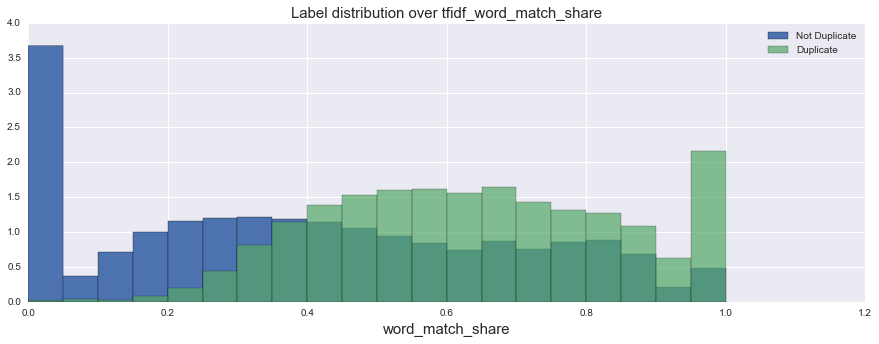

In [58]:
# Apply function above
tfidf_train_word_match = train_df.apply(tfidf_word_match_share, axis=1, raw=True)

#Plot
plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[train_df['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [59]:
from sklearn.metrics import roc_auc_score
print('Original AUC:', roc_auc_score(train_df['is_duplicate'], train_word_match))
print('   TFIDF AUC:', roc_auc_score(train_df['is_duplicate'], tfidf_train_word_match.fillna(0)))

Original AUC: 0.750733171571
   TFIDF AUC: 0.73919778921


In [60]:
train_df["tfidf_train_word_match"] = tfidf_train_word_match
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,bigrams_ques1,bigrams_ques2,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",5,0.833333,"[(step, step), (step, guide), (guide, invest),...","[(step, step), (step, guide), (guide, invest),...",5,0.833333,0.909091,0.971435
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,50,87,8,13,...,"[story, kohinoor, (, koh-i-noor, ), diamond]","[would, happen, indian, government, stole, koh...",5,0.416667,"[(story, kohinoor), (kohinoor, (), ((, koh-i-n...","[(would, happen), (happen, indian), (indian, g...",4,0.363636,0.461538,0.558679
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",2,0.222222,"[(increase, speed), (speed, internet), (intern...","[(internet, speed), (speed, increased), (incre...",0,0.000000,0.363636,0.345326
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when [math]23^{24}[/math] i...,0,48,63,11,9,...,"[mentally, lonely, solve]","[find, remainder, [, math, ], 23^, {, 24, }, [...",0,0.000000,"[(mentally, lonely), (lonely, solve)]","[(find, remainder), (remainder, [), ([, math),...",0,0.000000,0.000000,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,73,38,13,7,...,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",2,0.153846,"[(one, dissolve), (dissolve, water), (water, q...","[(fish, would), (would, survive), (survive, sa...",0,0.000000,0.266667,0.262525


### 2.6. Sentiment analysis

See the Rmarkdown.

In [61]:
sentiment_sum = pd.read_csv("data/sentiment_analysis/sentiment_sum.csv")
train_df = pd.concat([train_df, sentiment_sum], axis=1)
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,bigrams_ques1,bigrams_ques2,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match,sentiment_analysis_sum
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,65,56,14,12,...,"[step, step, guide, invest, share, market]",5,0.833333,"[(step, step), (step, guide), (guide, invest),...","[(step, step), (step, guide), (guide, invest),...",5,0.833333,0.909091,0.971435,10
1,1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,50,87,8,13,...,"[would, happen, indian, government, stole, koh...",5,0.416667,"[(story, kohinoor), (kohinoor, (), ((, koh-i-n...","[(would, happen), (happen, indian), (indian, g...",4,0.363636,0.461538,0.558679,7
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,72,58,14,10,...,"[internet, speed, increased, hacking, dns]",2,0.222222,"[(increase, speed), (speed, internet), (intern...","[(internet, speed), (speed, increased), (incre...",0,0.000000,0.363636,0.345326,9
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when [math]23^{24}[/math] i...,0,48,63,11,9,...,"[find, remainder, [, math, ], 23^, {, 24, }, [...",0,0.000000,"[(mentally, lonely), (lonely, solve)]","[(find, remainder), (remainder, [), ([, math),...",0,0.000000,0.000000,0.000000,5
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,73,38,13,7,...,"[fish, would, survive, salt, water]",2,0.153846,"[(one, dissolve), (dissolve, water), (water, q...","[(fish, would), (would, survive), (survive, sa...",0,0.000000,0.266667,0.262525,10


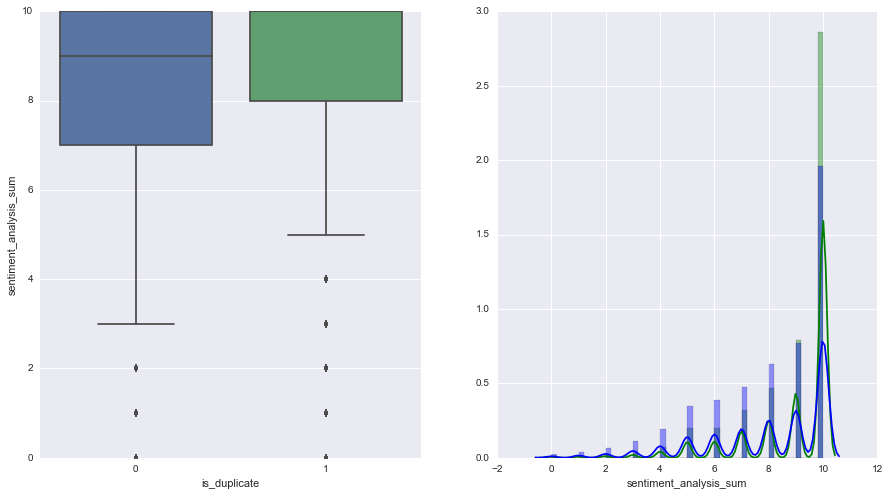

In [62]:
plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
sns.boxplot(x="is_duplicate", y="sentiment_analysis_sum", data=train_df)
plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1.0]['sentiment_analysis_sum'][:], color = 'green')
sns.distplot(train_df[train_df['is_duplicate'] == 0.0]['sentiment_analysis_sum'][:], color = 'blue')

The new feature, built from our R sentiment analysis, doesn't separate the target variable so well, but it will provide some useful insights into our model. Also, this new feature gives some general information that is not so much extracted by the previous features we created above. So, it should be valuable for our predictive task.

### 2.7.a. 3D t-SNE embedding
We will use t-SNE to embed the TF-IDF vectors in three dimensions and create an interactive scatter plot with them.

In [63]:
# For speed purposes
dfs = train_df[0:2500]

In [64]:
dfq1, dfq2 = dfs[['qid1', 'question1']], dfs[['qid2', 'question2']]
dfq1.columns = ['qid1', 'question']
dfq2.columns = ['qid2', 'question']

# merge two two dfs, there are two nans for question
dfqa = pd.concat((dfq1, dfq2), axis=0).fillna("")
nrows_for_q1 = dfqa.shape[0]/2
dfqa.shape

(5000, 3)

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
mq1 = TfidfVectorizer(max_features = 256).fit_transform(dfqa['question'].values)
mq1

<5000x256 sparse matrix of type '<class 'numpy.float64'>'
	with 31564 stored elements in Compressed Sparse Row format>

In [66]:
diff_encodings = np.abs(mq1[::2] - mq1[1::2])
diff_encodings

<2500x256 sparse matrix of type '<class 'numpy.float64'>'
	with 29462 stored elements in Compressed Sparse Row format>

In [67]:
from sklearn.manifold import TSNE
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(diff_encodings.toarray())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.465055
[t-SNE] Iteration 25: error = 1.6787571, gradient norm = 0.0106169
[t-SNE] Iteration 50: error = 1.6076828, gradient norm = 0.0102150
[t-SNE] Iteration 75: error = 1.3073155, gradient norm = 0.0031812
[t-SNE] Iteration 100: error = 1.2474579, gradient norm = 0.0041951
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.247458
[t-SNE] Iteration 125: error = 1.1496571, gradient norm = 0.0009950
[t-SNE] Iteration 125: gradient norm 0.000995. Finished.
[t-SNE] Error after 125 iterations: 1.247458


In [68]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = dfs['is_duplicate'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='test')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

### 2.7.b. Embedding with engineered features


In [69]:
from sklearn.preprocessing import MinMaxScaler

df_subsampled = train_df[0:3000]
X = MinMaxScaler().fit_transform(df_subsampled[['q1_n_words', 'q1len', 'sentiment_analysis_sum', 'q2_n_words','train_word_match', 'tfidf_train_word_match' ,'bigrams_common_ratio' ,'q2len', 'word_share', 'unigrams_common_ratio']])
y = df_subsampled['is_duplicate'].values

In [70]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=200,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.097192
[t-SNE] Iteration 25: error = 1.9726371, gradient norm = 0.0038053
[t-SNE] Iteration 50: error = 1.8679484, gradient norm = 0.0032197
[t-SNE] Iteration 75: error = 1.5402534, gradient norm = 0.0009735
[t-SNE] Iteration 75: gradient norm 0.000973. Finished.
[t-SNE] KL divergence after 75 iterations with early exaggeration: 1.540253
[t-SNE] Iteration 100: error = 1.4348171, gradient norm = 0.0005925
[t-SNE] Iteration 100: gradient norm 0.000593. Finished.
[t-SNE] Error after 100 iterations: 1.540253


In [71]:
trace1 = go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

ERROR! Session/line number was not unique in database. History logging moved to new session 269


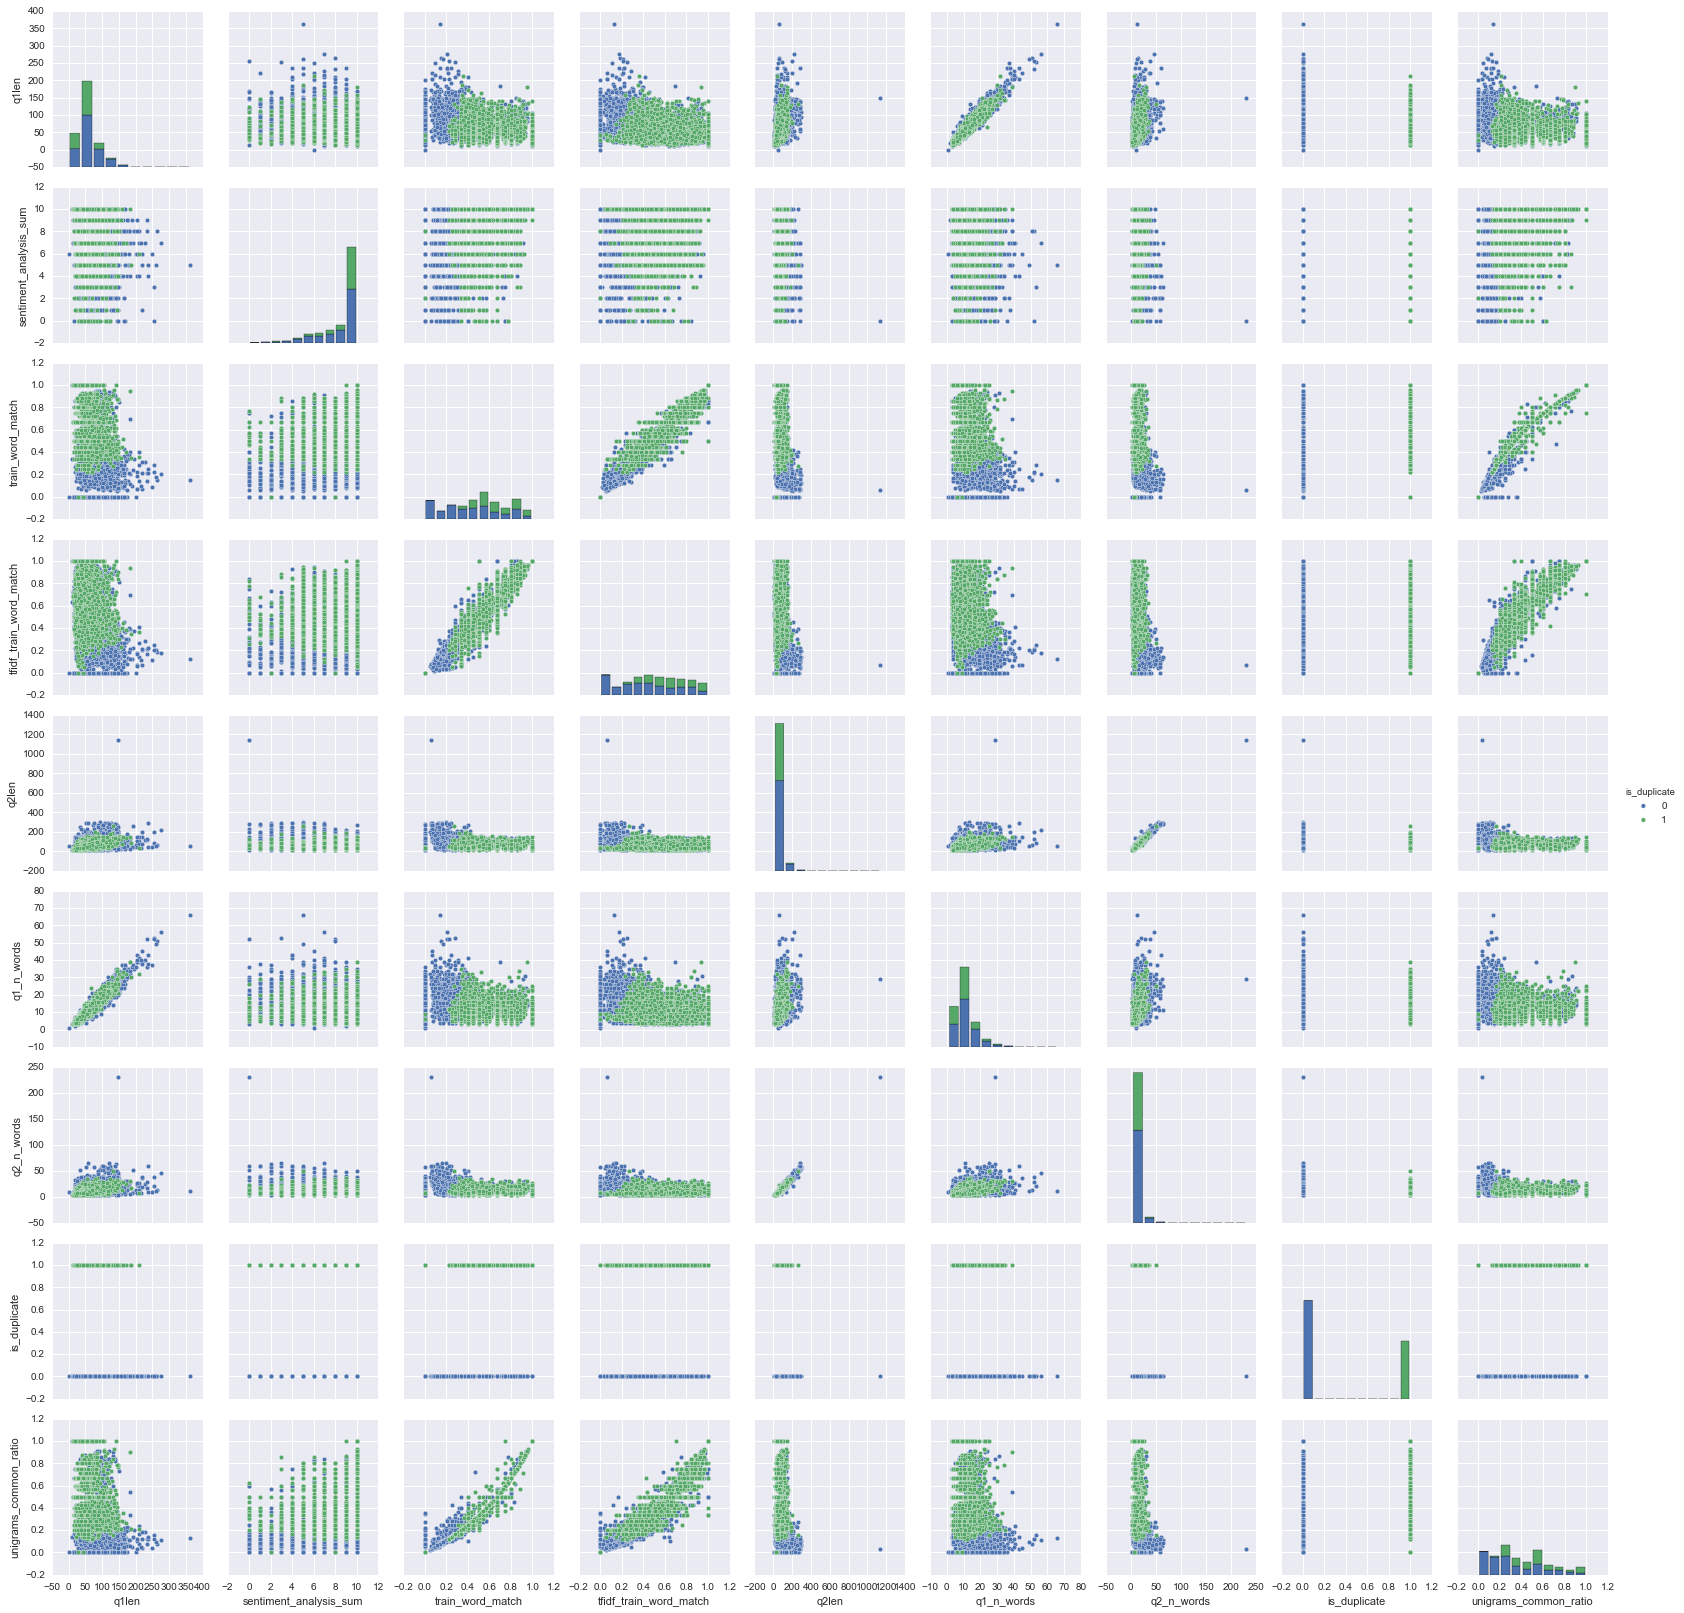

In [72]:
n = 10000
sns.pairplot(train_df[['q1len', 'sentiment_analysis_sum', 'train_word_match', 'tfidf_train_word_match', 'q2len', 'q1_n_words', 'q2_n_words', 'is_duplicate', 'unigrams_common_ratio']][0:n], hue='is_duplicate')

#### Absolute Difference between qid1 and qid2

Sources: https://www.kaggle.com/triskelion/quora-question-pairs/an-unusual-informative-feature

In [73]:
df_train = train_df
qid_abs_diff = list(abs(df_train["qid1"] - df_train["qid2"]))
df_leakage = pd.DataFrame({"qid_abs_diff": qid_abs_diff, "target": df_train["is_duplicate"]})
np.random.shuffle(qid_abs_diff)
df_leakage["qid_abs_diff_shuffled"] = qid_abs_diff


In [74]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

X = np.array(df_leakage["qid_abs_diff"]).reshape((df_leakage.shape[0], 1))
y = np.array(df_leakage["target"])

clf = RandomForestClassifier(random_state=1, n_estimators=50, n_jobs=-1)

skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

print("Absolute Difference between qid1 and qid2")
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    preds = clf.predict_proba(X_test)[:,1]
    print("Fold: %d"%(i+1))
    print("AUC: %f"%(roc_auc_score(y_test, preds)))
    print("LOGLOSS: %f\n"%(log_loss(y_test, preds)))

Absolute Difference between qid1 and qid2
Fold: 1
AUC: 0.649902
LOGLOSS: 1.485741

Fold: 2
AUC: 0.650352
LOGLOSS: 1.477232

Fold: 3
AUC: 0.650467
LOGLOSS: 1.506978

Fold: 4
AUC: 0.647068
LOGLOSS: 1.491411

Fold: 5
AUC: 0.652058
LOGLOSS: 1.497382



In [84]:
train_ready = train_df.drop(['qid1', 'qid2','question1', 'question2', 'unigrams_ques1', 'unigrams_ques2', 'bigrams_ques1', 'bigrams_ques2', 'id'], 1)
train_ready.head()

,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match,sentiment_analysis_sum
0,0,65,56,14,12,0.478261,5,0.833333,5,0.833333,0.909091,0.971435,10
1,0,50,87,8,13,0.250000,5,0.416667,4,0.363636,0.461538,0.558679,7
2,0,72,58,14,10,0.166667,2,0.222222,0,0.000000,0.363636,0.345326,9
3,0,48,63,11,9,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,5
4,0,73,38,13,7,0.200000,2,0.153846,0,0.000000,0.266667,0.262525,10


In [85]:
train_ready.to_csv("train_ready.csv")

***

# 3. Modeling 

### 3.1. Test set preparation

In [86]:
#1
test_df['q1len'] = test_df['question1'].str.len()
test_df['q2len'] = test_df['question2'].str.len()
test_df['q1_n_words'] = test_df['question1'].apply(lambda row: len(row.split(" ")))
test_df['q2_n_words'] = test_df['question2'].apply(lambda row: len(row.split(" ")))
test_df['word_share'] = test_df.apply(normalized_word_share, axis=1)

#2
test_df["unigrams_ques1"] = test_df['question1'].apply(lambda x: get_unigrams(str(x)))
test_df["unigrams_ques2"] = test_df['question2'].apply(lambda x: get_unigrams(str(x)))
test_df["unigrams_common_count"] = test_df.apply(lambda row: get_common_unigrams(row),axis=1)
test_df["unigrams_common_ratio"] = test_df.apply(lambda row: get_common_unigram_ratio(row), axis=1)

#3
test_df["bigrams_ques1"] = test_df["unigrams_ques1"].apply(lambda x: get_bigrams(x))
test_df["bigrams_ques2"] = test_df["unigrams_ques2"].apply(lambda x: get_bigrams(x)) 
test_df["bigrams_common_count"] = test_df.apply(lambda row: get_common_bigrams(row),axis=1)
test_df["bigrams_common_ratio"] = test_df.apply(lambda row: get_common_bigram_ratio(row), axis=1)

In [89]:
#4
test_df['train_word_match'] = test_df.apply(word_match_share, axis=1, raw=True)
test_df['tfidf_train_word_match'] = test_df.apply(tfidf_word_match_share, axis=1, raw=True)

test_df.head()

,test_id,question1,question2,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_ques1,unigrams_ques2,unigrams_common_count,unigrams_common_ratio,bigrams_ques1,bigrams_ques2,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match
0,0,how does the surface pro himself 4 compare wit...,why did microsoft choose core m3 and not core ...,56,67,11,14,0.130435,"[surface, pro, 4, compare, ipad, pro]","[microsoft, choose, core, m3, core, i3, home, ...",3,0.272727,"[(surface, pro), (pro, 4), (4, compare), (comp...","[(microsoft, choose), (choose, core), (core, m...",2,0.166667,0.428571,0.430700
1,1,should i have a hair transplant at age 24 how ...,how much cost does hair transplant require,64,42,14,7,0.238095,"[hair, transplant, age, 24, much, would, cost]","[much, cost, hair, transplant, require]",4,0.500000,"[(hair, transplant), (transplant, age), (age, ...","[(much, cost), (cost, hair), (hair, transplant...",1,0.111111,0.666667,0.663313
2,2,what but is the best way to send money from ch...,what you send money to china,59,28,14,6,0.277778,"[best, way, send, money, china, us]","[send, money, china]",3,0.500000,"[(best, way), (way, send), (send, money), (mon...","[(send, money), (money, china)]",2,0.400000,0.666667,0.807120
3,3,which food not emulsifiers,what foods fibre,26,16,4,3,0.000000,"[food, emulsifiers]","[foods, fibre]",0,0.000000,"[(food, emulsifiers)]","[(foods, fibre)]",0,0.000000,0.000000,0.000000
4,4,how aberystwyth start reading,how their can i start reading,29,29,4,6,0.300000,"[aberystwyth, start, reading]","[start, reading]",2,0.666667,"[(aberystwyth, start), (start, reading)]","[(start, reading)]",1,0.500000,0.800000,1.000000


In [91]:
test_ready = test_df.drop(['question1', 'question2', 'unigrams_ques1', 'unigrams_ques2', 'bigrams_ques1', 'bigrams_ques2'], 1)
test_ready.head()

,test_id,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match
0,0,56,67,11,14,0.130435,3,0.272727,2,0.166667,0.428571,0.430700
1,1,64,42,14,7,0.238095,4,0.500000,1,0.111111,0.666667,0.663313
2,2,59,28,14,6,0.277778,3,0.500000,2,0.400000,0.666667,0.807120
3,3,26,16,4,3,0.000000,0,0.000000,0,0.000000,0.000000,0.000000
4,4,29,29,4,6,0.300000,2,0.666667,1,0.500000,0.800000,1.000000


In [42]:
#import saved csv
test_ready = pd.read_csv("Data/modeling/test_ready_sanssentiment.csv").drop('Unnamed: 0',1)
train_ready = pd.read_csv("Data/modeling/train_ready.csv").drop('Unnamed: 0',1)

In [43]:
#sentiment analysis
sentiment_sum_test = pd.read_csv("data/sentiment_analysis/sentiment_sum_testset.csv").drop('Unnamed: 0',1)
test_ready = pd.concat([test_ready, sentiment_sum_test], axis=1)

In [44]:
test_ready.head()

,test_id,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match,sentiment_analysis_sum
0,0,56,67,11,14,0.130435,3,0.272727,2,0.166667,0.428571,0.430700,9
1,1,64,42,14,7,0.238095,4,0.500000,1,0.111111,0.666667,0.663313,10
2,2,59,28,14,6,0.277778,3,0.500000,2,0.400000,0.666667,0.807120,10
3,3,26,16,4,3,0.000000,0,0.000000,0,0.000000,0.000000,0.000000,7
4,4,29,29,4,6,0.300000,2,0.666667,1,0.500000,0.800000,1.000000,10


In [45]:
test_ready.to_csv("test_ready.csv")

### 3.2. Scaling

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [31]:
cols_to_norm = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'unigrams_common_count', 'bigrams_common_count', 'sentiment_analysis_sum']
train_ready[cols_to_norm] = train_ready[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

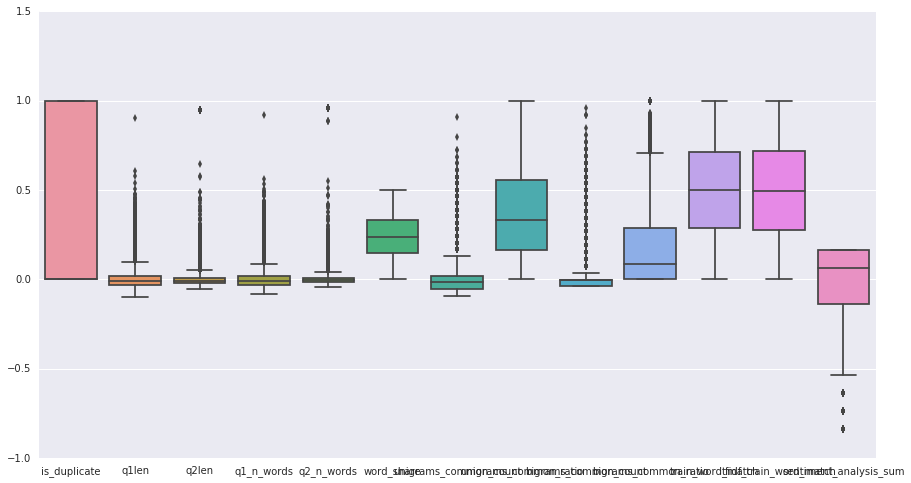

In [32]:
plt.figure(figsize=(15, 8))
#train_df.boxplot(return_type='axes')
sns.boxplot(data = train_ready)

In [33]:
train_ready.to_csv("modeling_train_ready.csv")

In [35]:
train_ready.shape

(404290, 13)

In [46]:
cols_to_norm = ['q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'unigrams_common_count', 'bigrams_common_count', 'sentiment_analysis_sum']
test_ready[cols_to_norm] = test_ready[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

In [47]:
test_ready.head()

,test_id,q1len,q2len,q1_n_words,q2_n_words,word_share,unigrams_common_count,unigrams_common_ratio,bigrams_common_count,bigrams_common_ratio,train_word_match,tfidf_train_word_match,sentiment_analysis_sum
0,0,-0.002418,0.007276,-0.000200,0.011753,0.130435,0.037169,0.272727,0.030904,0.166667,0.428571,0.430700,0.113307
1,1,0.004575,-0.014558,0.011897,-0.016473,0.238095,0.069427,0.500000,0.009165,0.111111,0.666667,0.663313,0.213307
2,2,0.000205,-0.026785,0.011897,-0.020505,0.277778,0.037169,0.500000,0.030904,0.400000,0.666667,0.807120,0.213307
3,3,-0.028641,-0.037265,-0.028426,-0.032602,0.000000,-0.059605,0.000000,-0.012574,0.000000,0.000000,0.000000,-0.086693
4,4,-0.026019,-0.025912,-0.028426,-0.020505,0.300000,0.004911,0.666667,0.009165,0.500000,0.800000,1.000000,0.213307


In [49]:
test_ready.to_csv("modeling_test_ready.csv")